## Import Modules

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D

## Load the Dataset

In [2]:
DATASET = 'affectnet'
# DATASET = 'fer2013'
# DATASET = 'mma'

TRAIN_DIR = f"input/{DATASET}/train/"
TEST_DIR = f"input/{DATASET}/test/"
VALID_DIR = f"input/{DATASET}/valid/"

In [3]:
def load_dataset(directory):
    image_paths = []
    labels = []

    for label in os.listdir(directory):
        for filename in os.listdir(directory+label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)

        # print(label, "Completed")

    return image_paths, labels

In [4]:
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
train = train.sample(frac=1).reset_index(drop=True) # shuffle

train.head()

,image,label
0,input/affectnet/train/angry\image0000450.jpg,angry
1,input/affectnet/train/neutral\ffhq_4041.png,neutral
2,input/affectnet/train/disgust\image0037401.jpg,disgust
3,input/affectnet/train/angry\image0025459.jpg,angry
4,input/affectnet/train/surprise\image0031752.jpg,surprise


In [5]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)
test = test.sample(frac=1).reset_index(drop=True)

test.head()

,image,label
0,input/affectnet/test/fear\image0039237.jpg,fear
1,input/affectnet/test/surprise\image0006234.jpg,surprise
2,input/affectnet/test/angry\image0001527.jpg,angry
3,input/affectnet/test/sad\image0025517.jpg,sad
4,input/affectnet/test/sad\image0029071.jpg,sad


In [6]:
valid = pd.DataFrame()
valid['image'], valid['label'] = load_dataset(VALID_DIR)
valid = valid.sample(frac=1).reset_index(drop=True)

valid.head()

,image,label
0,input/affectnet/valid/disgust\image0038289.jpg,disgust
1,input/affectnet/valid/happy\ffhq_1478.png,happy
2,input/affectnet/valid/sad\image0029062.jpg,sad
3,input/affectnet/valid/surprise\image0034346.jpg,surprise
4,input/affectnet/valid/happy\ffhq_908.png,happy


## Exploratory Data Analysis

<Axes: xlabel='count', ylabel='label'>

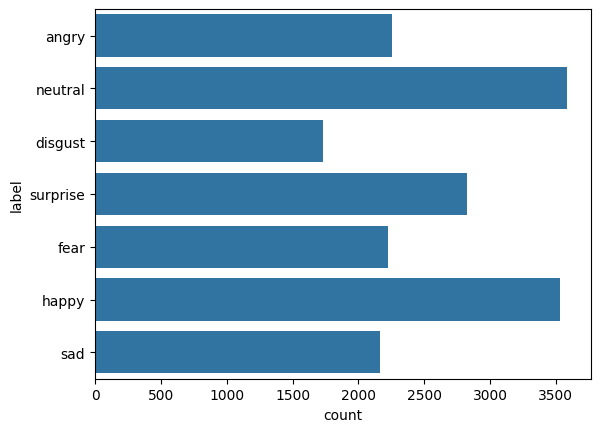

In [7]:
sns.countplot(train['label'])

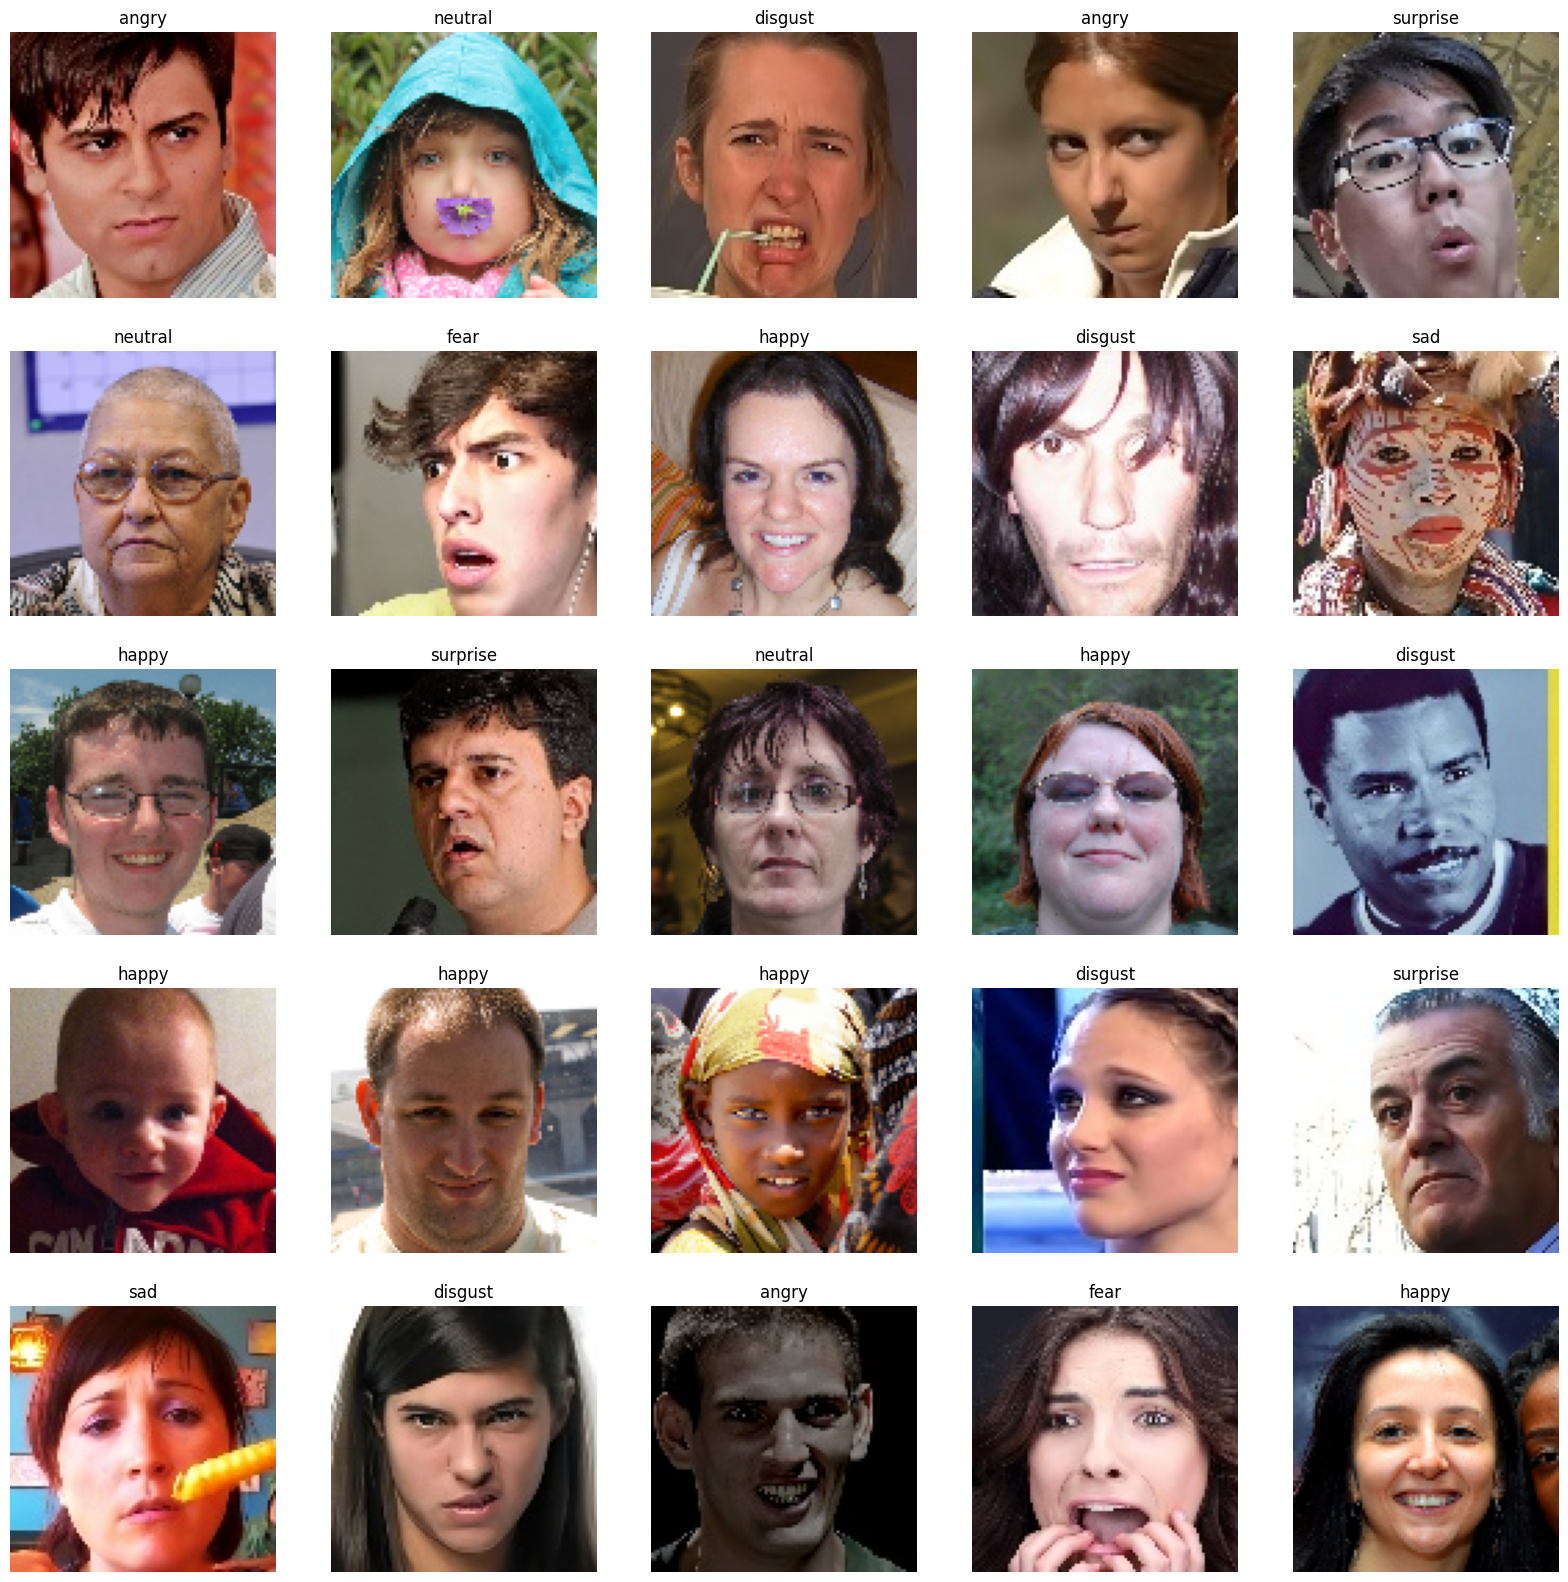

In [8]:
# display grid of images
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, image_path, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(image_path)
    img = np.array(img)
    
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

## Feature Extraction

In [9]:
def extract_features(images):
    features = []
    for image_path in tqdm(images):
        img = load_img(image_path, color_mode='grayscale')
        img = np.array(img)
        
        if DATASET == 'affectnet': # affectnet images are 96x96
            img = img[::2, ::2] # so downsampling to 48x48 is required
        
        features.append(img)
    
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)
    
    return features

In [10]:
train_features = extract_features(train['image'])
x_train = train_features / 255.0

  0%|          | 0/18316 [00:00<?, ?it/s]

In [11]:
test_features = extract_features(test['image'])
x_test = test_features / 255.0

  0%|          | 0/2617 [00:00<?, ?it/s]

In [12]:
valid_features = extract_features(valid['image'])
x_valid = valid_features / 255.0

  0%|          | 0/5238 [00:00<?, ?it/s]

In [13]:
labels = train['label'].unique()
print(labels)

['angry' 'neutral' 'disgust' 'surprise' 'fear' 'happy' 'sad']


In [14]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(labels)

y_train = le.transform(train['label'])
y_test = le.transform(test['label'])
y_valid = le.transform(valid['label'])

In [15]:
y_train = to_categorical(y_train, num_classes=len(labels))
y_test = to_categorical(y_test, num_classes=len(labels))
y_valid = to_categorical(y_valid, num_classes=len(labels))

In [16]:
y_train[0]

array([1., 0., 0., 0., 0., 0., 0.])

In [17]:
# config
input_shape = (48, 48, 1)
output_class = len(labels)

## Model Creation

In [18]:
# # 5 layer model
# model = Sequential(name='5-layer')

# # convolutional layers
# model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(1024, kernel_size=(3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
# model.add(Dropout(0.25))

# model.add(Conv2D(1024, kernel_size=(3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# # fatten layer
# model.add(Flatten())

# # fully connected layers
# model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

# model.add(Dense(256, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

# # output layer
# model.add(Dense(output_class, activation='softmax'))

# _______________________________________________________

# 6 layer model
model = Sequential(name='6-layer')

# Convolutional layers
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(1024, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(1024, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.25))

model.add(Conv2D(2048, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# global average pooling layer
model.add(GlobalAveragePooling2D())

# fully connected layers
model.add(Dense(output_class, activation='softmax'))

In [19]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "6-layer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 1024)          │       4,719,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 6, 6, 1024)          │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 3, 3, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 3, 3, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 3, 3, 1024)          │       9,438,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 3, 3, 1024)          │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 2, 2, 1024)          │              

 Total params: 34,545,159 (131.78 MB)

 Trainable params: 34,535,175 (131.74 MB)

 Non-trainable params: 9,984 (39.00 KB)

In [ ]:
# train the model
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=32,
    epochs=100,
    validation_data=(x_valid, y_valid)
)

Epoch 1/100
573/573 ━━━━━━━━━━━━━━━━━━━━ 369s 640ms/step - accuracy: 0.2627 - loss: 3.1306 - val_accuracy: 0.1562 - val_loss: 9.2347
Epoch 2/100
573/573 ━━━━━━━━━━━━━━━━━━━━ 351s 612ms/step - accuracy: 0.4586 - loss: 2.0311 - val_accuracy: 0.4595 - val_loss: 1.3863
Epoch 3/100
573/573 ━━━━━━━━━━━━━━━━━━━━ 348s 608ms/step - accuracy: 0.5039 - loss: 1.8163 - val_accuracy: 0.5452 - val_loss: 1.1073
Epoch 4/100
573/573 ━━━━━━━━━━━━━━━━━━━━ 357s 623ms/step - accuracy: 0.5538 - loss: 1.1227 - val_accuracy: 0.5645 - val_loss: 1.0819
Epoch 5/100
573/573 ━━━━━━━━━━━━━━━━━━━━ 354s 618ms/step - accuracy: 0.5818 - loss: 1.0554 - val_accuracy: 0.3677 - val_loss: 52.9941
Epoch 6/100
573/573 ━━━━━━━━━━━━━━━━━━━━ 352s 615ms/step - accuracy: 0.5712 - loss: 1.1016 - val_accuracy: 0.6002 - val_loss: 0.9916
Epoch 7/100
573/573 ━━━━━━━━━━━━━━━━━━━━ 353s 616ms/step - accuracy: 0.5878 - loss: 1.0979 - val_accuracy: 0.5977 - val_loss: 1.0162
Epoch 8/100
573/573 ━━━━━━━━━━━━━━━━━━━━ 352s 615ms/step - accuracy:

In [ ]:
# save the model
model.save(f'models/{DATASET}_6layer.keras')

## Plot the Results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()

## Accuracy, F1, Precision, Recall

In [ ]:
from sklearn.metrics import classification_report

# Przewidywanie klas na zestawie testowym
y_pred_prob = model.predict(x_test)
y_pred = np.array([np.eye(len(row))[np.argmax(row)] for row in y_pred_prob])

# Obliczenie miar
report = classification_report(y_test, y_pred, target_names=labels)

print(report)

## Test with Image Data

In [ ]:
plt.figure(figsize=(20,20))

for i in range(20):
    plt.subplot(5, 5, i+1)

    img_index = random.randint(0, len(test))
    img = x_test[img_index]
    
    label = test['label'][img_index]

    pred = model.predict(img.reshape(1, 48, 48, 1), verbose=0)
    pred_label = le.inverse_transform([pred.argmax()])[0]
    
    plt.title(f"{img_index}. label: {label} | pred: {pred_label}")
    plt.imshow(img.reshape(48, 48), cmap='gray')
    plt.axis('off')